Imports

In [7]:
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.stats import wilcoxon, ttest_rel


Paths

In [8]:
# Project root (macOS)
PROJECT_ROOT = Path("/Users/srinivass/Budgetaware_hpo")

BASELINE_FILE = PROJECT_ROOT / "results" / "baselines" / "mlp_baseline_covertype.csv"
HPO_FILE = PROJECT_ROOT / "results" / "hpo" / "mlp_hpo_summary_covertype.csv"

METHOD_TO_TEST = "successive_halving"   # or "random_search"

print("Baseline file exists:", BASELINE_FILE.exists())
print("HPO file exists:", HPO_FILE.exists())


Baseline file exists: True
HPO file exists: True


Load data

In [9]:
baseline_df = pd.read_csv(BASELINE_FILE)
hpo_df = pd.read_csv(HPO_FILE)

print("Baseline columns:", baseline_df.columns.tolist())
print("HPO columns:", hpo_df.columns.tolist())

baseline_df.head(), hpo_df.head()


Baseline columns: ['dataset', 'seed', 'f1_macro']
HPO columns: ['dataset', 'seed', 'method', 'val_f1']


(     dataset  seed  f1_macro
 0  covertype     0  0.815739
 1  covertype     1  0.818796
 2  covertype     2  0.810980
 3  covertype     3  0.814035
 4  covertype     4  0.810579,
      dataset  seed              method    val_f1
 0  covertype     0       random_search  0.887256
 1  covertype     0  successive_halving  0.850828
 2  covertype     1       random_search  0.885487
 3  covertype     1  successive_halving  0.885487
 4  covertype     2       random_search  0.873075)

In [10]:
# Normalize dataset names
baseline_df["dataset"] = baseline_df["dataset"].str.strip().str.lower()
hpo_df["dataset"] = hpo_df["dataset"].str.strip().str.lower()

# Ensure seeds are integers
baseline_df["seed"] = baseline_df["seed"].astype(int)
hpo_df["seed"] = hpo_df["seed"].astype(int)

print("Baseline datasets:", baseline_df["dataset"].unique())
print("HPO datasets:", hpo_df["dataset"].unique())

print("Baseline seeds:", sorted(baseline_df["seed"].unique()))
print("HPO seeds:", sorted(hpo_df["seed"].unique()))


Baseline datasets: ['covertype']
HPO datasets: ['covertype']
Baseline seeds: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
HPO seeds: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


Helper functions

In [11]:
# Baseline (test F1)
b = baseline_df.rename(
    columns={"f1_macro": "f1_baseline"}
)[["dataset", "seed", "f1_baseline"]]

# HPO (validation F1)
h = hpo_df[hpo_df["method"] == METHOD_TO_TEST].rename(
    columns={"val_f1": "f1_hpo"}
)[["dataset", "seed", "f1_hpo"]]

# Pair by dataset + seed
paired = b.merge(h, on=["dataset", "seed"], how="inner")

print("Paired rows (after intersecting seeds):", len(paired))
paired.head()


Paired rows (after intersecting seeds): 10


,dataset,seed,f1_baseline,f1_hpo
0,covertype,0,0.815739,0.850828
1,covertype,1,0.818796,0.885487
2,covertype,2,0.810980,0.828663
3,covertype,3,0.814035,0.878380
4,covertype,4,0.810579,0.869799


Build paired comparison table (baseline vs HPO)

In [12]:
paired["delta_f1"] = paired["f1_hpo"] - paired["f1_baseline"]

paired


,dataset,seed,f1_baseline,f1_hpo,delta_f1
0,covertype,0,0.815739,0.850828,0.035089
1,covertype,1,0.818796,0.885487,0.066692
2,covertype,2,0.810980,0.828663,0.017683
3,covertype,3,0.814035,0.878380,0.064345
4,covertype,4,0.810579,0.869799,0.059221
5,covertype,5,0.797585,0.867198,0.069613
6,covertype,6,0.815260,0.866903,0.051643
7,covertype,7,0.794478,0.879300,0.084822
8,covertype,8,0.815186,0.869067,0.053881
9,covertype,9,0.825980,0.868202,0.042222


Stats Summary and improvement % Chek

In [13]:
deltas = paired["delta_f1"].values

mean_delta = deltas.mean()
ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])

print(f"Mean improvement (ΔF1): {mean_delta:.4f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

# Wilcoxon signed-rank (one-sided: HPO > baseline)
w_stat, w_p = wilcoxon(deltas, alternative="greater")

# Paired t-test (two-sided)
t_stat, t_p = ttest_rel(
    paired["f1_hpo"], paired["f1_baseline"]
)

print(f"Wilcoxon p-value (HPO > baseline): {w_p}")
print(f"Paired t-test p-value: {t_p}")

print("Meets ≥ 0.05 absolute improvement?",
      "YES" if mean_delta >= 0.05 else "NO")


Mean improvement (ΔF1): 0.0545
95% CI: [0.0216, 0.0814]
Wilcoxon p-value (HPO > baseline): 0.0009765625
Paired t-test p-value: 8.58522239361795e-06
Meets ≥ 0.05 absolute improvement? YES


Hypothesis tests (paired t-test + Wilcoxon)

In [14]:
print("DATASET: covertype")
print("METHOD:", METHOD_TO_TEST)
print("Pairs used:", len(paired))
print(f"Mean ΔF1: {mean_delta:.4f}")
print(f"Wilcoxon p-value: {w_p}")
print(f"Paired t-test p-value: {t_p}")


DATASET: covertype
METHOD: successive_halving
Pairs used: 10
Mean ΔF1: 0.0545
Wilcoxon p-value: 0.0009765625
Paired t-test p-value: 8.58522239361795e-06


Plot

/var/folders/yd/_lghqqgn6q33nqvzyyyh8n6h0000gn/T/ipykernel_5938/1710404311.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


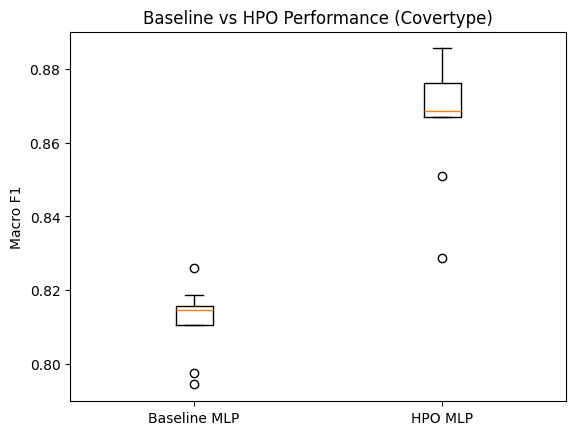

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(
    [paired["f1_baseline"], paired["f1_hpo"]],
    labels=["Baseline MLP", "HPO MLP"]
)
plt.ylabel("Macro F1")
plt.title("Baseline vs HPO Performance (Covertype)")
plt.show()


Conclusion

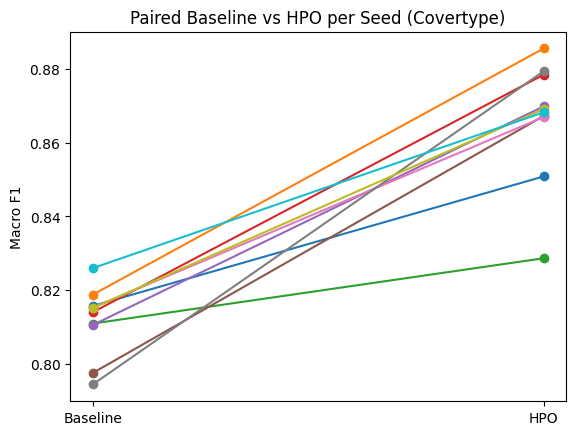

In [16]:
plt.figure()

for _, row in paired.iterrows():
    plt.plot(
        ["Baseline", "HPO"],
        [row["f1_baseline"], row["f1_hpo"]],
        marker="o"
    )

plt.ylabel("Macro F1")
plt.title("Paired Baseline vs HPO per Seed (Covertype)")
plt.show()


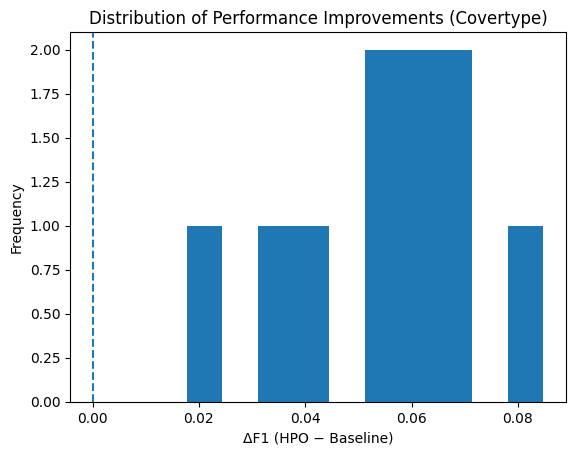

In [17]:
plt.figure()
plt.hist(paired["delta_f1"], bins=10)
plt.axvline(0, linestyle="--")
plt.xlabel("ΔF1 (HPO − Baseline)")
plt.ylabel("Frequency")
plt.title("Distribution of Performance Improvements (Covertype)")
plt.show()


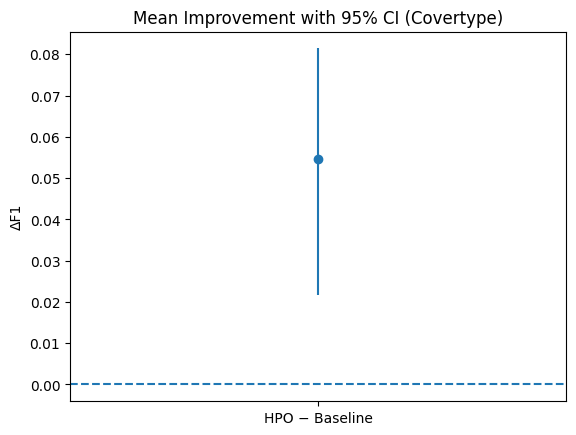

In [18]:
mean_delta = paired["delta_f1"].mean()
ci_low, ci_high = np.percentile(paired["delta_f1"], [2.5, 97.5])

plt.figure()
plt.errorbar(
    x=[0],
    y=[mean_delta],
    yerr=[[mean_delta - ci_low], [ci_high - mean_delta]],
    fmt="o"
)
plt.axhline(0, linestyle="--")
plt.xticks([0], ["HPO − Baseline"])
plt.ylabel("ΔF1")
plt.title("Mean Improvement with 95% CI (Covertype)")
plt.show()
